https://sejaumdatascientist.com/como-criar-um-programa-de-fidelidade-para-empresa/

# Cicle

### Cicle 01
- Foundout 3 potencial clusters using the data as it is.

Next cicles:
- Need to make some feature engineering
- Deal with NA values
- Run others clustering algorithms

### Cicle 02
- Data is still messy. Got a similar cluster as cicle 01.
- Dealt with NA values
- Have runned other clustering algorithms to find a optimal cluster

Next cicles:
- Need to make some feature engineering

# 0.0. Planejamento da Solução ( IOT )

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - **Alto Ticket Médio**
                + média dos preços pagos
            - **Alto LTV (life time value)**
                + quanto foi gasto na empresa
            - **Baixa Recência ou Alta Frequência**
                + tempo entre as compras - contado em dias
            - **Alto Basket Size**
                + quantidade média de produtos comprados
            - **Baixa probabilidade de Churn**
                + encerramento de contrato ou baixa da relação com a empresa
            - **Previsão alta de LTV**
            - **Alta propensão de compra**

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País / Localização
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Atributos da clusterização / Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Análise de Cohort (marcação do grupo e seu comportamento ao longo do tempo)
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ? (1 mês, 3 meses...?)
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection
import sklearn
import yellowbrick
import umap.umap_ as umap
from matplotlib import pyplot as plt

from pandas_profiling import ProfileReport

from IPython.core.display import HTML
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import mixture       as mx
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly import express as px

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def describe_num(num_attributes):
    a = num_attributes.describe().T.reset_index()
    
    d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T      
    d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply( lambda x: x.unique().shape[0])).T
    
    n = pd.concat([d4, d5, d6, d7], axis=0).T.reset_index()
    n.columns = ['attibutes', 'range', 'skew', 'kurtosis', 'unique']
    b = a.merge(n, right_on='attibutes', left_on='index')
    b.drop('index', axis=1, inplace=True)
    columns = ['attibutes', 'count', 'mean', 'std', '25%', '50%', '75%', 'min', 'max', 'range',
           'skew', 'kurtosis', 'unique']
    return b[columns]

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [3]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv',encoding='unicode_escape')

# drop extra columns
df_raw.drop('Unnamed: 8', axis=1, inplace=True)

# <font color='red'> 1.0. Descrição dos dados </font>

In [4]:
df1 = df_raw.copy()
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Rename columuns

In [6]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
# storing columns names
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

#renaming columns name
df1.columns = cols_new

## 1.2. Data dimensions

In [6]:
df1.shape

(541909, 8)

## 1.3. Data types

In [6]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

## 1.4. Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

### 1.5.1 Description

In [7]:
# replace with existing description by stock_code
df1aux = df1[~df1['description'].isna()]
aux3 = df1aux[['stock_code', 'description']].drop_duplicates('stock_code')
df1 = df1.drop(columns='description')
df1_ = pd.merge(df1, aux3, how='left', on='stock_code')
df1_.isna().sum()

invoice_no           0
stock_code           0
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
description        112
dtype: int64

In [8]:
# the remaing 112 records have 0 values for unit_price. it is going to bel erased
df1_ = df1_.dropna(subset=['description'])

df1 = df1_.copy()

df1_.isna().sum()

invoice_no           0
stock_code           0
quantity             0
invoice_date         0
unit_price           0
customer_id     134968
country              0
description          0
dtype: int64

### 1.5.2 Customer ID 

In [9]:
df1['customer_id'].isna().sum()/df1.shape[0]

0.24911175218762746

In [10]:
aux_na = df1[df1['customer_id'].isna()].copy()
aux_na['gross_revenue_na'] = aux_na['unit_price']*aux_na['quantity']
print("Total Gross Revenue NA $ %.2f" % aux_na['gross_revenue_na'].sum())
aux = df1[~df1['customer_id'].isna()].copy()
aux['gross_revenue_na'] = aux['unit_price']*aux['quantity']
print("Total Gross Revenue $ %.2f" % aux['gross_revenue_na'].sum())
print("Percentage of Total (not NA): %.2f" % (aux_na['gross_revenue_na'].sum()/aux['gross_revenue_na'].sum()*100), '%')

Total Gross Revenue NA $ 1447682.12
Total Gross Revenue $ 8300065.81
Percentage of Total (not NA): 17.44 %


In [11]:
df1_ = df1.copy()
df1_.shape

(541797, 8)

In [12]:
# create reference - artificial customer to not drop the records
df_backup = pd.DataFrame( aux_na['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 30000, 30000+len( df_backup ), 1) 

# merge original with reference dataframe
df1_ = pd.merge( df1_, df_backup, on='invoice_no', how='left' )

# coalesce (command from SQL)
df1_['customer_id'] = df1_['customer_id_x'].combine_first( df1_['customer_id_y'] )

# drop extra columns
df1_ = df1_.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [13]:
df1 = df1_.copy()
df1_.isna().sum()

invoice_no      0
stock_code      0
quantity        0
invoice_date    0
unit_price      0
country         0
description     0
customer_id     0
dtype: int64

## 1.6. Change dtypes

In [14]:
# customer_id
df1['customer_id'] = df1['customer_id'].astype('int32')
df1['quantity'] = df1['quantity'].astype('int32')
df1.dtypes

invoice_no              object
stock_code              object
quantity                 int32
invoice_date    datetime64[ns]
unit_price             float64
country                 object
description             object
customer_id              int32
dtype: object

## 1.7. Descriptive Statistics

In [19]:
num_attributes = df1.select_dtypes(include=['int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'float64', 'datetime64[ns]'])

## 1.7.1. Numerical Attibutes

In [20]:
describe_num(num_attributes)

,attibutes,count,mean,std,25%,50%,75%,min,max,range,skew,kurtosis,unique
0,quantity,541797.0,9.555919,218.103428,1.00,3.00,10.00,-80995.00,80995.0,161990.00,-0.264100,119744.998246,722.0
1,unit_price,541797.0,4.612067,96.769831,1.25,2.08,4.13,-11062.06,38970.0,50032.06,186.487799,58993.571524,1630.0
2,customer_id,541797.0,16668.598606,2879.319954,14367.00,16245.00,18283.00,12346.00,22597.0,10251.00,0.467760,-0.825461,7970.0


**quantity** - There is some strange values in the max and min values. Need further investigation

**unit_price** - There is some product with price equals 0 and a max values of 38.970. Need further investigation

## 1.7.2. Categorical Attibutes

In [115]:
cat_attributes.apply( lambda x: x.unique().shape[0])

invoice_no     25788
stock_code      3958
country           38
description     3817
dtype: int64

# <font color='red'> 2.0. Feature Engineering </font>

In [15]:
df2 = df1.copy()
df2.columns

Index(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price',
       'country', 'description', 'customer_id'],
      dtype='object')

In [175]:
df2.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,description,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,WHITE METAL LANTERN,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,CREAM CUPID HEARTS COAT HANGER,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,17850


### 2.1. GROSS REVENUE

In [16]:
# gross revenue
df2['gross_revenue'] = df2['unit_price'] * df2['quantity']

### 2.2. GOOD RETURN

In [17]:
df2['good_return'] = df2.apply(lambda x: 1 if (x['quantity'] < 0) & (x['unit_price'] > 0) else 0, axis=1)

### 2.3. QNTD ADJUSTMENT

In [18]:
df2['qtd_adjustment'] = df2.apply(lambda x: 1 if (x['quantity'] < 0) & (x['unit_price'] == 0) else 0, axis=1)

### 2.4. FREE PURCHASE

In [19]:
df2['free_purchase'] = df2.apply(lambda x: 1 if (x['quantity'] > 0) & (x['unit_price'] == 0) else 0, axis=1)

### 2.5. NORMAL PURCHASE

In [20]:
df2['normal_purchase'] = df2.apply(lambda x: 1 if (x['quantity'] > 0) & (x['unit_price'] > 0) else 0, axis=1)

In [21]:
df2.sample(40)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,description,customer_id,gross_revenue,good_return,qtd_adjustment,free_purchase,normal_purchase
75604,542607,22131,3,2017-01-28,1.95,United Kingdom,FOOD CONTAINER SET 3 LOVE HEART,13148,5.85,0,0,0,1
190866,553224,23154,2,2017-05-14,2.08,United Kingdom,SET OF 4 JAM JAR MAGNETS,17228,4.16,0,0,0,1
435729,574076,35649,1,2017-10-31,2.46,United Kingdom,VINTAGE BEAD COSMETIC BAG,33158,2.46,0,0,0,1
449347,575128,22141,6,2017-11-06,2.10,United Kingdom,CHRISTMAS CRAFT TREE TOP ANGEL,16837,12.60,0,0,0,1
81201,543116,22698,6,2017-02-01,2.95,United Kingdom,PINK REGENCY TEACUP AND SAUCER,17672,17.70,0,0,0,1
476524,577029,84077,48,2017-11-15,0.29,United Kingdom,WORLD WAR 2 GLIDERS ASSTD DESIGNS,15563,13.92,0,0,0,1
118061,546422,85184C,1,2017-03-11,2.95,United Kingdom,S/4 VALENTINE DECOUPAGE HEART BOX,15547,2.95,0,0,0,1
5298,536857,22900,5,2016-12-01,2.95,United Kingdom,SET 2 TEA TOWELS I LOVE LONDON,16883,14.75,0,0,0,1
430085,573583,72807A,5,2017-10-29,4.25,United Kingdom,SET/3 ROSE CANDLE IN JEWELLED BOX,14167,21.25,0,0,0,1
453703,575491,22749,1,2017-11-07,3.75,United Kingdom,FELTCRAFT PRINCESS CHARLOTTE DOLL,15531,3.75,0,0,0,1


# <font color='red'> 3.0. Filtragem de Variaveis </font>

In [22]:
df3 = df2.copy()
df3.columns

Index(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price',
       'country', 'description', 'customer_id', 'gross_revenue', 'good_return',
       'qtd_adjustment', 'free_purchase', 'normal_purchase'],
      dtype='object')

In [27]:
df3.shape

(541797, 13)

## 3.1. Row Filtering

In [23]:
# Qntd Adjustment - There is no reason to maintain this records in the data.
df3 = df3[df3['qtd_adjustment'] == 0]
df3.shape

(540558, 13)

## 3.2. Column Filtering

In [24]:
df3 = df3.drop(columns=['qtd_adjustment'])

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [25]:
df4 = df3.copy()
df4.shape

(540558, 12)

## 4.1. Analyzing by class

### 4.1.1. Normal Purchase

In [32]:
df4_np = df4[df4['normal_purchase'] == 1]

In [194]:
profile = ProfileReport( df4_np )
profile.to_file( 'normal_purchase.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\kaotc\anaconda3\envs\pa005\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

* invoice_no - total of 19960 orders / invoice 573585 have 1114 itens in the basket (doubled compared to previous invoice), it is import to analyze how this basket is composed.

* stock_code - total of 3922 code / the most frequent is 85123A

* quantity - Maximum is strange with 80995 itens maybe it is a outlier. there is others with high vales we need to understand

* invoice_date - histogram have low sales frequency in the begining of year. sales era better close to Christimas.

* unit_price - the range of prices is a little bit awkward. need further investigation

* country - UK have the most of sales. Other country have no revelance. It is important how much these countries spend on this store.

* description - mail out is the most frequent value. investigate if it is important to clustering.

In [196]:
len(df4_np['stock_code'].unique())

3922

### 4.1.2. Good Return

In [34]:
df4_gr = df4[df4['good_return'] == 1]

In [35]:
profile = ProfileReport( df4_gr )
profile.to_file( 'good_return.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

* invoice_no - total of 3836 orders / C570878 have returned the most products (101 in total)

* stock_code - total of 1947 code / the most frequent is M (manual) and there other not products like D and S. Need to understand it is important.

* quantity - Minimum is strange with -80995 itens maybe it is a outlier. there is others with lower vales we need to understand

* invoice_date - most of returns had happened between september and november.

* unit_price - the range of prices is a little bit awkward. need further investigation

* country - UK have the most of sales. Other country have no revelance. It is important how much these countries spend on this store.

* description - manual, postage, discount and sample have several quantity amount.

### 4.1.3. Free Purchase

In [36]:
df4_fp = df4[df4['free_purchase'] == 1]

In [37]:
profile = ProfileReport( df4_fp )
profile.to_file( 'free_purchase.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

* invoice_no - total of 804 orders / 539856 have the most of free itens (64 in total)

* stock_code - total of 666 code / the most frequent is 23084 with 13 in total.

* quantity - Maximum is strange with 12540 itens maybe it is a outlier. there is others with lower vales we need to understand

* invoice_date - most of gift was given in july and in the end of year.

* country - UK have the most of sales. Other country have no revelance. It is important how much these countries spend on this store.

* description - rabbit night light have the most given away. there is no a huge rule for this gift.

## 4.2. Feature Analysis

### 4.2.1. Stock Code

In [26]:
# products have a code + a digit (if this product have a variation). "Not product" have single character or other configuration.
df4['not_product'] = df4['stock_code'].apply(lambda x: 1 if re.search('\D{2,}', x) else 0)

In [27]:
text = df4[df4['not_product'] == 1]['description'].unique().tolist()
aux = df4[df4['description'].isin(text)]

In [28]:
# 1. Removing generated customers with no value for clustering
# there is a bunch of records we cannot attach to a regular customer (customer_id >=30000) directly. This records is going to be removed from the dataset since there is no use for it.
aux_nc = aux[aux['customer_id'] >= 30000]
a = aux_nc[['gross_revenue','stock_code']].groupby('stock_code').count().reset_index()
print('Total of records with stock_code not generated by regular customer: ', a['gross_revenue'].sum())
rm_index = aux_nc.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]

# 2. Bank Charges
# there is a total of 12 records named with bank charges. It is not related to a purchase invoice and it is a single record for customer.
# Since it is not possible to assess the meaning and this information is irrevelant, this record is going to be removed.
df4 = df4[~(df4['stock_code'] == 'BANK CHARGES')]

# 3. CRUK Comission
# there is a total of 16 records named with CRUK Comission. It is related only to the customer nº14096
# Since it is not possible to assess the meaning and this information is irrevelant, this record is going to be removed.
df4 = df4[~(df4['stock_code'] == 'CRUK')]

# 3. DOT
# there is a total of 16 records named with DOT POSTAGE. It is related only to the customer nº14096
# Since this is a cost for this buyer, and it is not a product by it self, this record is going to be removed
df4 = df4[~(df4['stock_code'] == 'DOT')]

# 4. PADS
# there is a total of 4 records named with PADS.
# The price is very low for this product and it seems there is no use for it. This record is going to be removed.
df4 = df4[~(df4['stock_code'] == 'PADS')]

# 5. POSTAL
# We are going to separate the cost of postal from gross revenue (1196)
# The specific records for this cost it is going to be removed from the main dataset (df4)
a = df4[df4['stock_code'] == 'POST']
df_postal = a[['invoice_no', 'gross_revenue']].groupby('invoice_no').sum().rename( columns={'gross_revenue': 'total_postal'}).reset_index()
rm_index = a.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]

# DROP NOT_PRODUCT COLUMNS
df4 = df4.drop(columns='not_product')

Total of records with stock_code not generated by regular customer:  972


In [78]:
# Analyzing each stock_code which is not a product
#text = df4[df4['not_product'] == 1]['description'].unique().tolist()
#aux = df4[df4['description'].isin(text)]
#aux.sample(40)
#a = aux[['gross_revenue','stock_code']].groupby('stock_code').count().reset_index()
#a = pd.merge(a, aux[['stock_code', 'description']], on='stock_code', how='inner').drop_duplicates()
#a

### 4.2.2. Unit Price

#### FREE PRODUCT - QTD + / Unit Price = 0

In [29]:
# 1114 of "free product" are related to fake customers which we don´t have previous information
# only 39 records are related to existing customer (indicated on dataset). most of customer bought just once, so it seems there is no reason to keep this records with products with value "0"
#fp = df4[(df4['free_purchase']==1) & (df4['customer_id']<30000)]
#fp[['customer_id', 'invoice_no', 'free_purchase']].groupby(['customer_id', 'invoice_no']).count().cumsum()

a = df4[df4['free_purchase'] == 1]
rm_index = a.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]
df4 = df4.drop(columns='free_purchase')
df4.shape

(537189, 11)

#### GOOD RETURN - QTD - / Unit Price +

In [30]:
# There is 296 records with product return related to fake customers. Since we cannot identify or work with this information, we are going to delete it.
gr = df4[(df4['good_return']==1) & (df4['customer_id']>=30000)]
rm_index = gr.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]

In [31]:
# the rest of returned product is related to a customer. we are going to sepate it from gross_revenue creating a new column 'total_returned'
df4['quantity'] = df4.apply(lambda x: 0 if x['good_return']==1 else x['quantity'], axis=1)
df4['unit_price'] = df4.apply(lambda x: 0 if x['good_return']==1 else x['unit_price'], axis=1)
df4['total_returned'] = df4.apply(lambda x: 0 if x['good_return']==0 else x['gross_revenue'], axis=1)
df4['gross_revenue'] = df4.apply(lambda x: 0 if x['good_return']==1 else x['gross_revenue'], axis=1)
df4 = df4.drop('good_return', axis=1)

#### NORMAL PURCHASE - QTD + / Unit Price +

In [32]:
# Manually input values we are going to remove from 'gross_revenue' section. A new section called 'manual_p' is created.
df4['quantity'] = df4.apply(lambda x: 0 if x['description']=='Manual' else x['quantity'], axis=1)
df4['unit_price'] = df4.apply(lambda x: 0 if x['description']=='Manual' else x['unit_price'], axis=1)
df4['manual_p'] = df4.apply(lambda x: x['gross_revenue'] if x['description']=='Manual' else 0, axis=1)
df4['gross_revenue'] = df4.apply(lambda x: 0 if x['description']=='Manual' else x['gross_revenue'], axis=1)

# Moving 'Manual' which cancels with 'total_return'. The sum is going to be only returned products and excluding manual input error.
df4['manual_p'] = df4.apply(lambda x: x['total_returned'] if (x['description']=='Manual') & (x['total_returned']<0) else x['manual_p'], axis=1)
df4['total_returned'] = df4.apply(lambda x: 0 if x['description']=='Manual' else x['total_returned'], axis=1)

In [33]:
# 'Adjust bad debt' is related to 3 customers which don´t have purchase in this data base. we are going to remove it
abd = df4[df4['description'] == 'Adjust bad debt']
rm_index = abd.index.tolist()
df4 = df4[~df4.index.isin(rm_index)]
df4 = df4.drop('normal_purchase', axis=1)

In [42]:
df4.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,description,customer_id,gross_revenue,total_returned,manual_p
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,17850,15.30,0.0,0.0
1,536365,71053,6,2016-11-29,3.39,United Kingdom,WHITE METAL LANTERN,17850,20.34,0.0,0.0
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,CREAM CUPID HEARTS COAT HANGER,17850,22.00,0.0,0.0
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,17850,20.34,0.0,0.0
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,17850,20.34,0.0,0.0


# <font color='red'> 5.0. Data Preparation </font>

In [119]:
df5 = df4.copy()
df5.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,description,customer_id,gross_revenue,total_returned,manual_p
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,17850,15.30,0.0,0.0
1,536365,71053,6,2016-11-29,3.39,United Kingdom,WHITE METAL LANTERN,17850,20.34,0.0,0.0
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,CREAM CUPID HEARTS COAT HANGER,17850,22.00,0.0,0.0
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,17850,20.34,0.0,0.0
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,17850,20.34,0.0,0.0


In [120]:
df5 = df5.drop(columns=['stock_code', 'description', 'country'])

In [121]:
df_ref_s = df5.groupby(['customer_id', 'invoice_no']).sum().reset_index()
df_ref_s = pd.merge(df_ref_s, df_postal, on='invoice_no', how='left' )
df_ref_s['total_postal'] = df_ref_s.apply(lambda x: x['total_postal'] if x['total_postal'] > 0 else 0, axis=1)
df_ref_q = df5[['invoice_no', 'customer_id']].groupby('invoice_no').count().reset_index()
df_ref_q = df_ref_q.rename(columns={'customer_id' : 'total_invoice'})
df5_ = pd.merge(df_ref_s, df_ref_q, on='invoice_no', how='left' )

In [122]:
df5_.isna().sum()

customer_id       0
invoice_no        0
quantity          0
unit_price        0
gross_revenue     0
total_returned    0
manual_p          0
total_postal      0
total_invoice     0
dtype: int64

In [123]:
df5 = df5_[['customer_id', 'quantity', 'unit_price', 'gross_revenue', 'total_returned', 'manual_p', 'total_postal', 'total_invoice']].groupby('customer_id').sum().reset_index()
df5['gross_revenue_adj'] = df5['gross_revenue'] + df5['total_returned'] + df5['manual_p']

In [124]:
# to use on cluster analyzis
df5_p = df5.copy()
df5 = df5.drop(columns=['customer_id'])

In [125]:
df5.head()

,quantity,unit_price,gross_revenue,total_returned,manual_p,total_postal,total_invoice,gross_revenue_adj
0,74215,1.04,77183.60,-77183.6,0.0,0.0,2,0.00
1,2458,481.21,4310.00,0.0,0.0,0.0,182,4310.00
2,2332,18.71,1437.24,0.0,0.0,360.0,27,1437.24
3,630,305.10,1457.55,0.0,0.0,300.0,72,1457.55
4,196,25.30,294.40,0.0,0.0,40.0,16,294.40


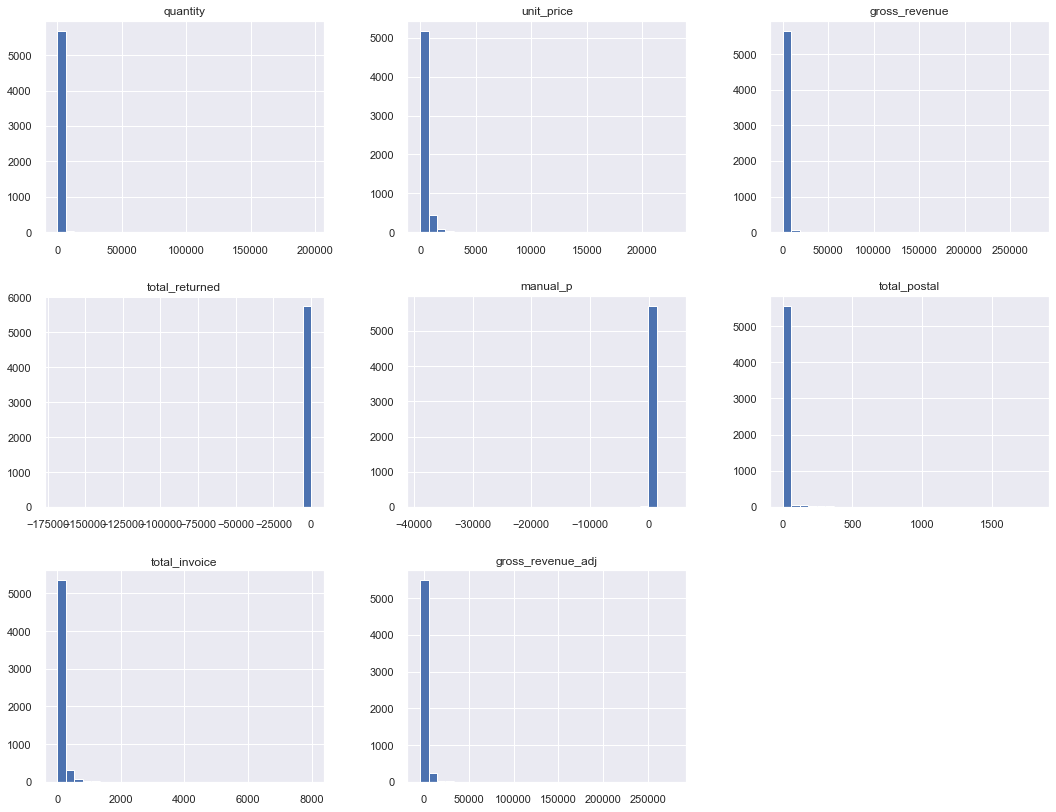

In [53]:
df5.hist(bins=30, figsize = (18,14));

<Figure size 1800x864 with 0 Axes>

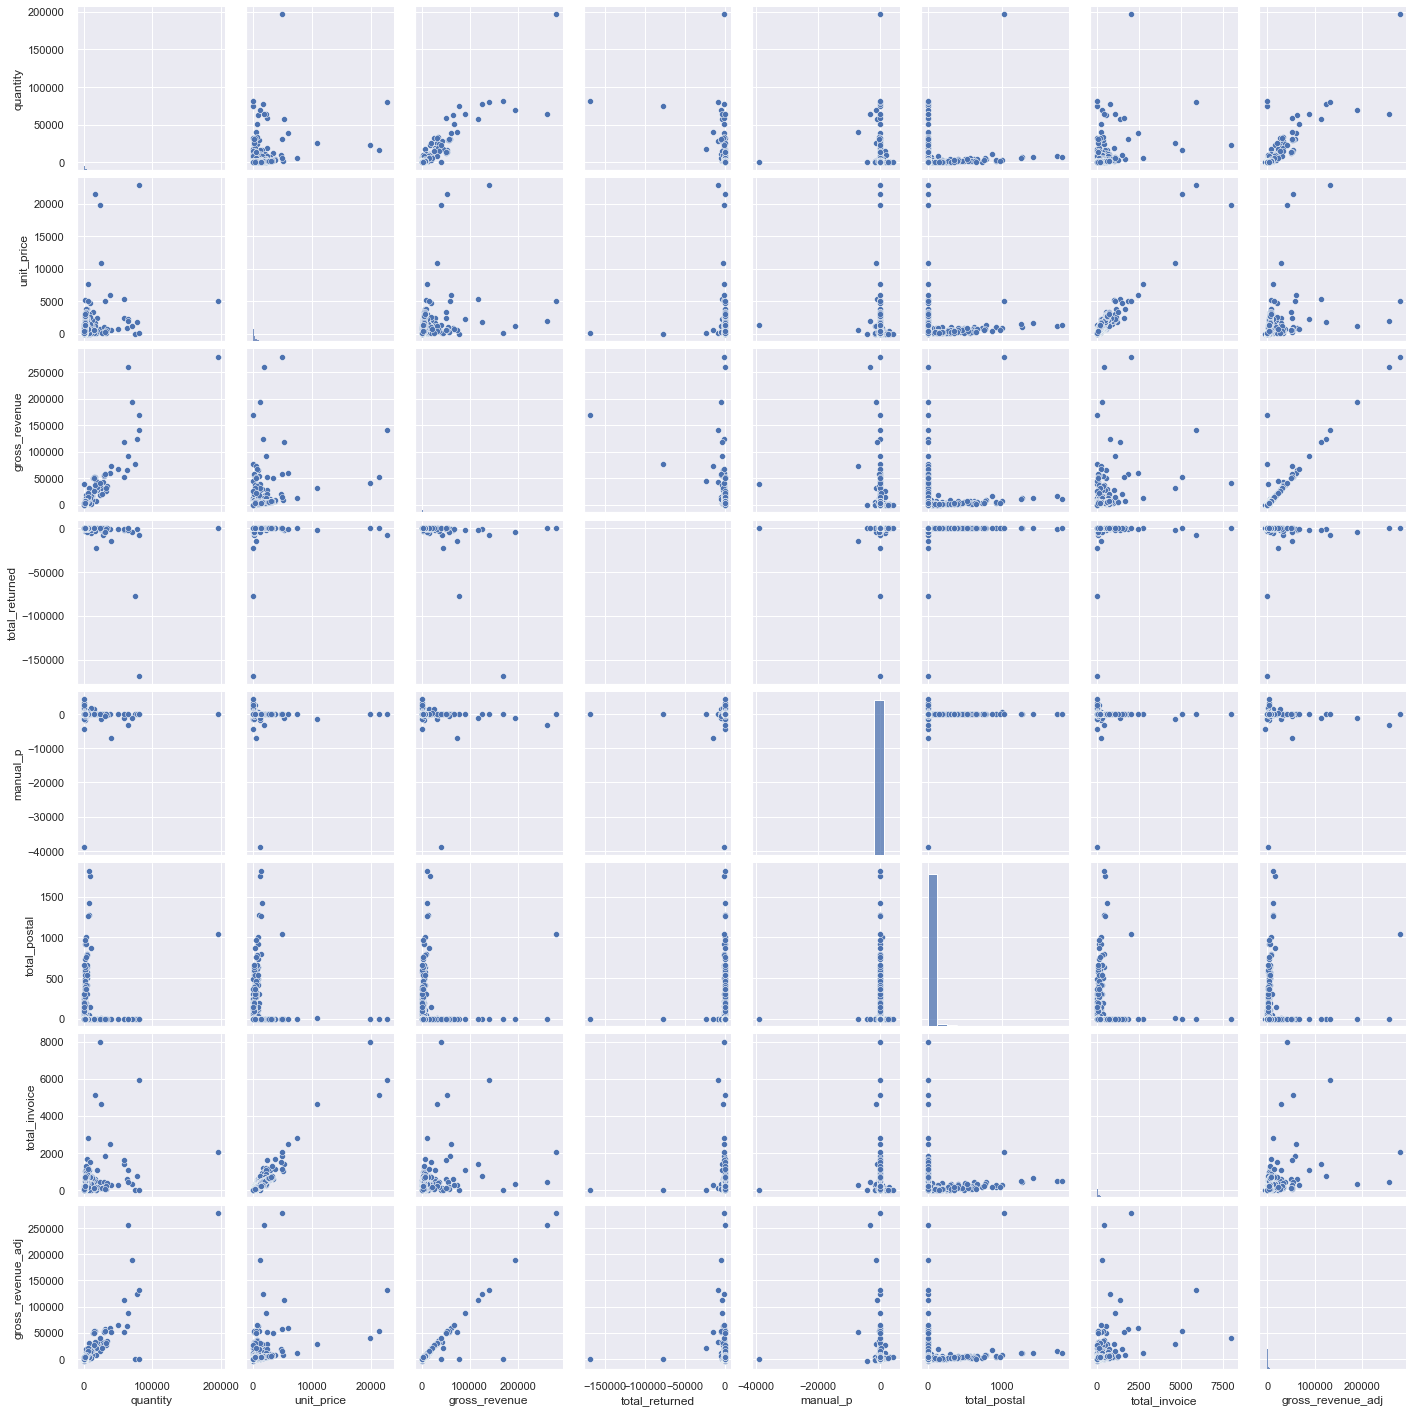

In [54]:
plt.figure( figsize=(25, 12) )
sns.pairplot( df5 )

## 5.1. NORMALIZATION

In [ ]:
# No potencial normal distribution

## 5.2. RESCALLING

In [109]:
df5.columns

Index(['quantity', 'unit_price', 'gross_revenue', 'total_returned', 'manual_p',
       'total_postal', 'total_invoice', 'gross_revenue_adj'],
      dtype='object')

In [126]:
mm_qt = pp.MinMaxScaler()
df5['quantity'] = mm_qt.fit_transform(df5[['quantity']].values)

mm_up = pp.MinMaxScaler()
df5['unit_price'] = mm_up.fit_transform(df5[['unit_price']].values)

mm_gr = pp.MinMaxScaler()
df5['gross_revenue'] = mm_gr.fit_transform(df5[['gross_revenue']].values)

mm_tr = pp.MinMaxScaler()
df5['total_returned'] = mm_tr.fit_transform(df5[['total_returned']].values)

mm_mp = pp.MinMaxScaler()
df5['manual_p'] = mm_mp.fit_transform(df5[['total_postal']].values)

mm_tp = pp.MinMaxScaler()
df5['total_postal'] = mm_tp.fit_transform(df5[['total_postal']].values)

mm_ti = pp.MinMaxScaler()
df5['total_invoice'] = mm_ti.fit_transform(df5[['total_invoice']].values)

mm_gra = pp.MinMaxScaler()
df5['gross_revenue_adj'] = mm_gra.fit_transform(df5[['gross_revenue_adj']].values)

## 5.3. TRANSFORMATION

In [243]:
#le_ct = pp.LabelEncoder()
#df5['country'] = le_ct.fit_transform(df5['country'])
##
## state_holiday - One Hot Encoding
#df5 = pd.get_dummies(df5, prefix=['country'], columns=['country'])

In [127]:
df5.head()

,quantity,unit_price,gross_revenue,total_returned,manual_p,total_postal,total_invoice,gross_revenue_adj
0,0.377024,0.000046,0.276507,0.541854,0.000000,0.000000,0.000125,0.015164
1,0.012487,0.021095,0.015440,1.000000,0.000000,0.000000,0.022676,0.030407
2,0.011847,0.000820,0.005149,1.000000,0.197802,0.197802,0.003257,0.020247
3,0.003201,0.013375,0.005222,1.000000,0.164835,0.164835,0.008895,0.020319
4,0.000996,0.001109,0.001055,1.000000,0.021978,0.021978,0.001879,0.016205


# <font color='red'> 6.0. Feature Selection </font>

# <font color='red'> 7.0 MACHINE LEARNING MODELLING </font>

In [128]:
X = df5.copy()

In [129]:
clusters = [2, 5, 10, 20, 35, 75, 125, 200, 450]

In [130]:
X.shape

(5771, 8)

## 7.1. Defining the number of Clusers - K-Means

In [131]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )
    #print('Cluster: ', k, 'Silhoutte Score: ', sil)

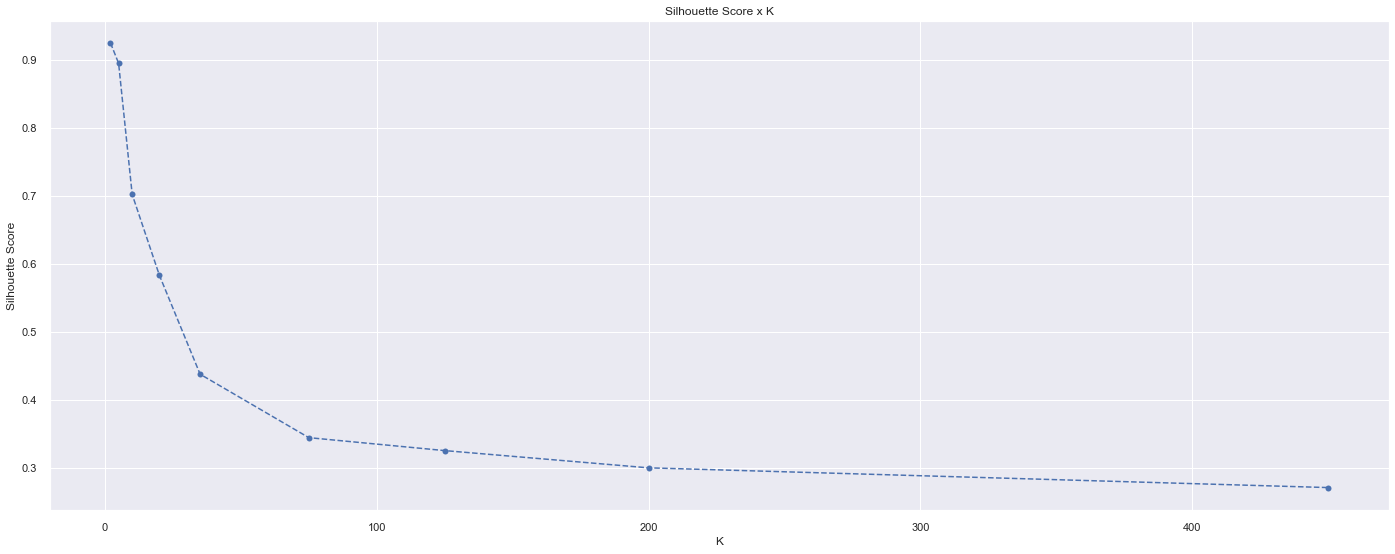

In [132]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2. GMM

In [133]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

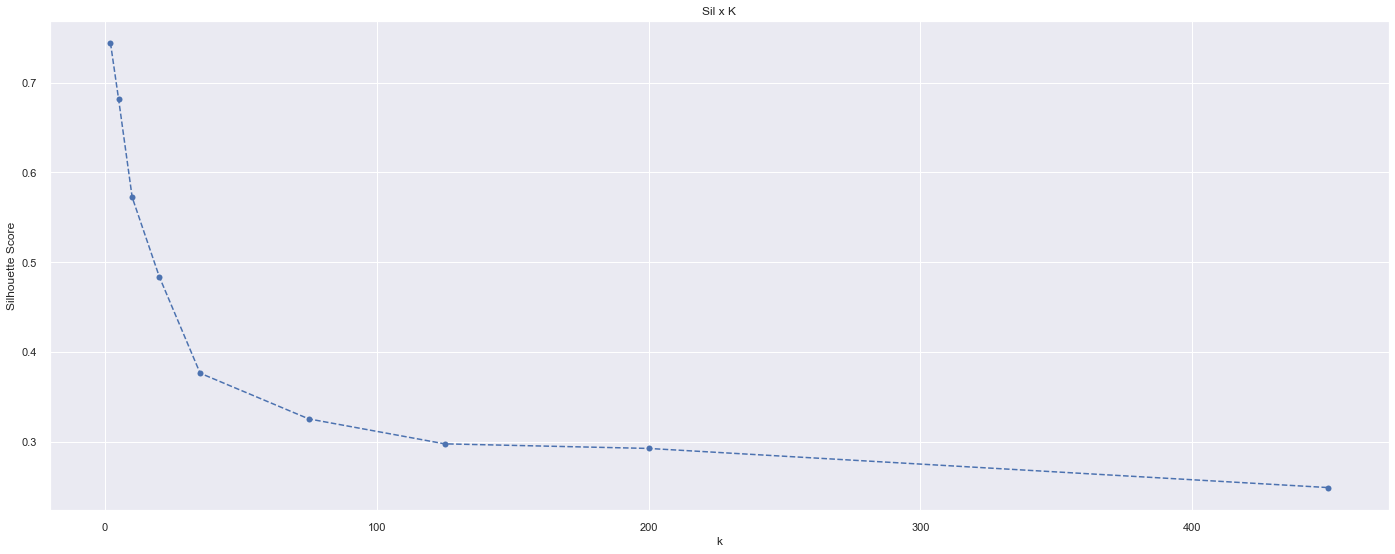

In [134]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3. Hierarchical Clustering

In [135]:
from scipy.cluster import hierarchy as hc

In [136]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

[]

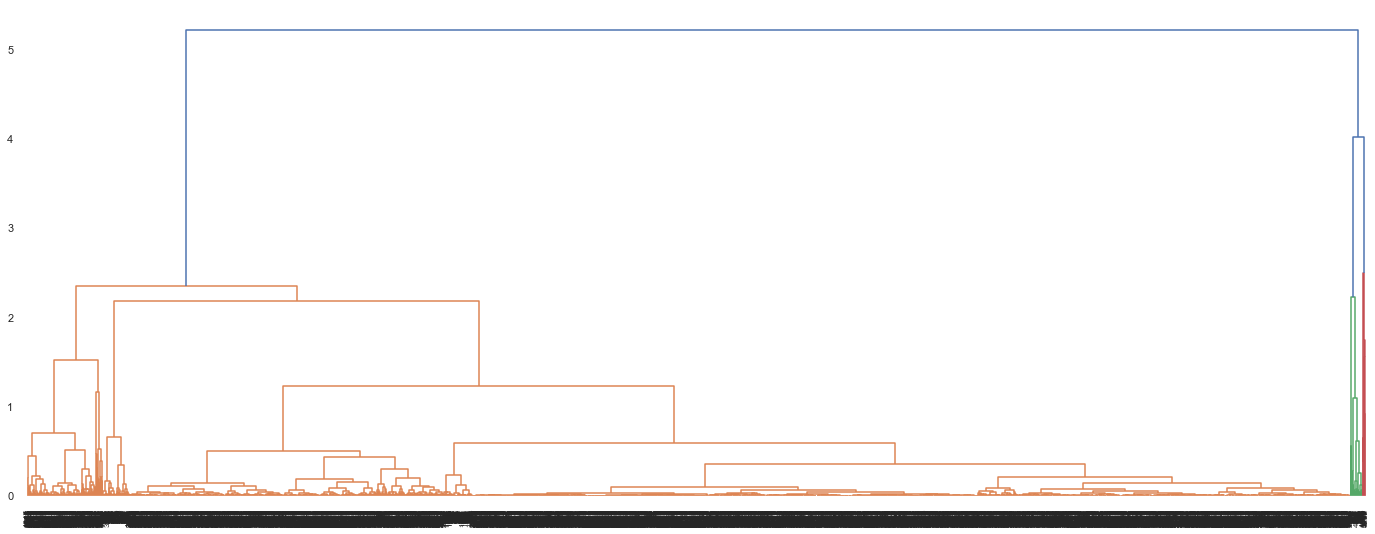

In [137]:
hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

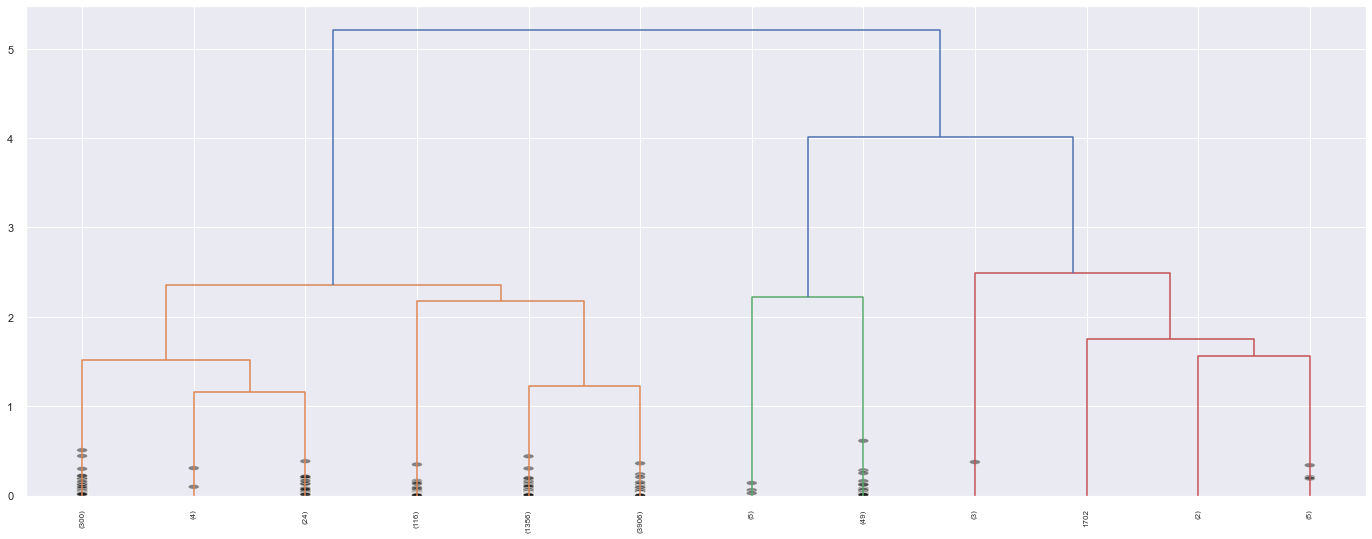

In [138]:
hc.dendrogram( 
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show()

### 7.3.1. HClustering Silhouette Score

In [139]:
from sklearn import metrics as m

In [140]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

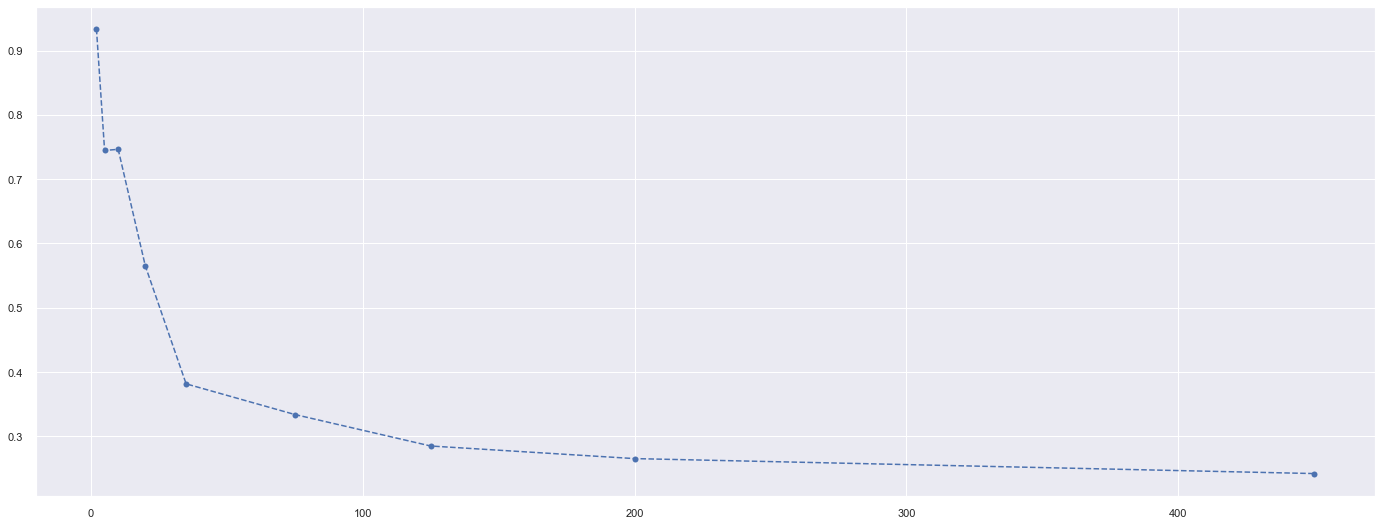

In [141]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.4. DBSCAN

In [373]:
eps=0.3
min_samples=20 

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
print( unique( labels ) )

Silhouette Score: 0.89798739696239
Number of Clusters: 4
[-1  0  1  2]


In [374]:
from sklearn.neighbors import NearestNeighbors

In [375]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

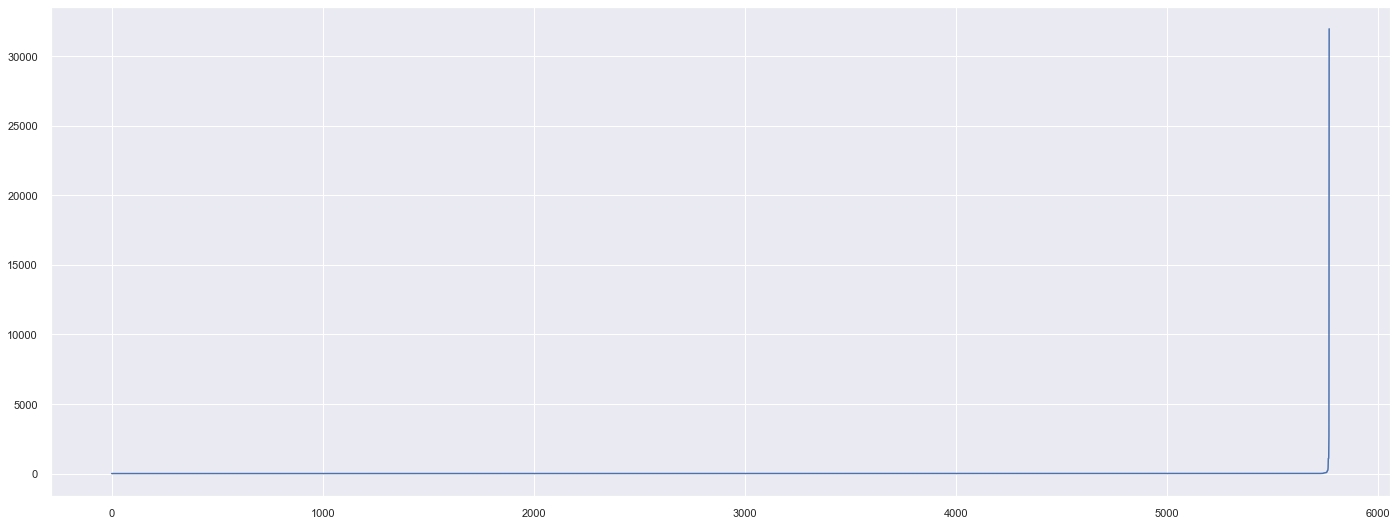

In [378]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

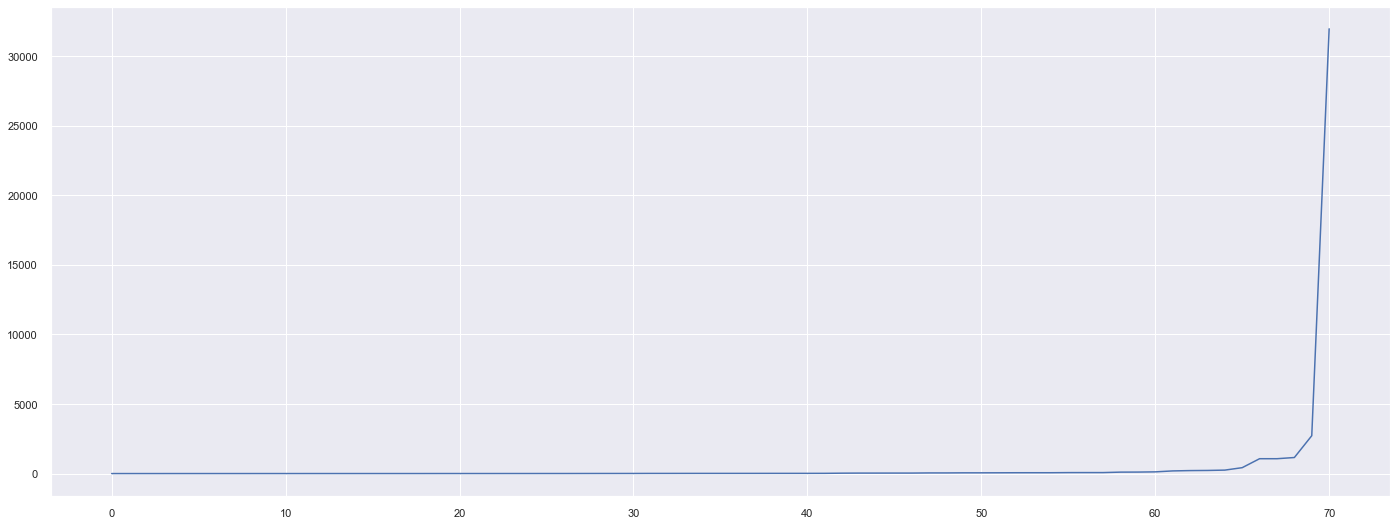

In [382]:
plt.plot( distances[5700:] )

In [38]:
dbscan_list = [ 0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5. Results

In [142]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list, 
     #'DBSCAN': dbscan_list
    }
).T

df_results.columns = clusters

In [143]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,5,10,20,35,75,125,200,450
KMeans,0.924723,0.894596,0.701643,0.582903,0.437273,0.343988,0.324944,0.299599,0.270575
GMM,0.744564,0.681718,0.572282,0.483592,0.376201,0.325216,0.297412,0.292296,0.248670
HC,0.933795,0.744634,0.746413,0.564877,0.381747,0.334083,0.285117,0.265541,0.242273


## 7.6. Silhouette Analysis

In [144]:
len(clusters)

9

 For K = 2. Silhouette Score: 0.9337950125871561
 For K = 5. Silhouette Score: 0.7446341308149412
 For K = 10. Silhouette Score: 0.7464125449542081


IndexError: index 9 is out of bounds for axis 0 with size 5

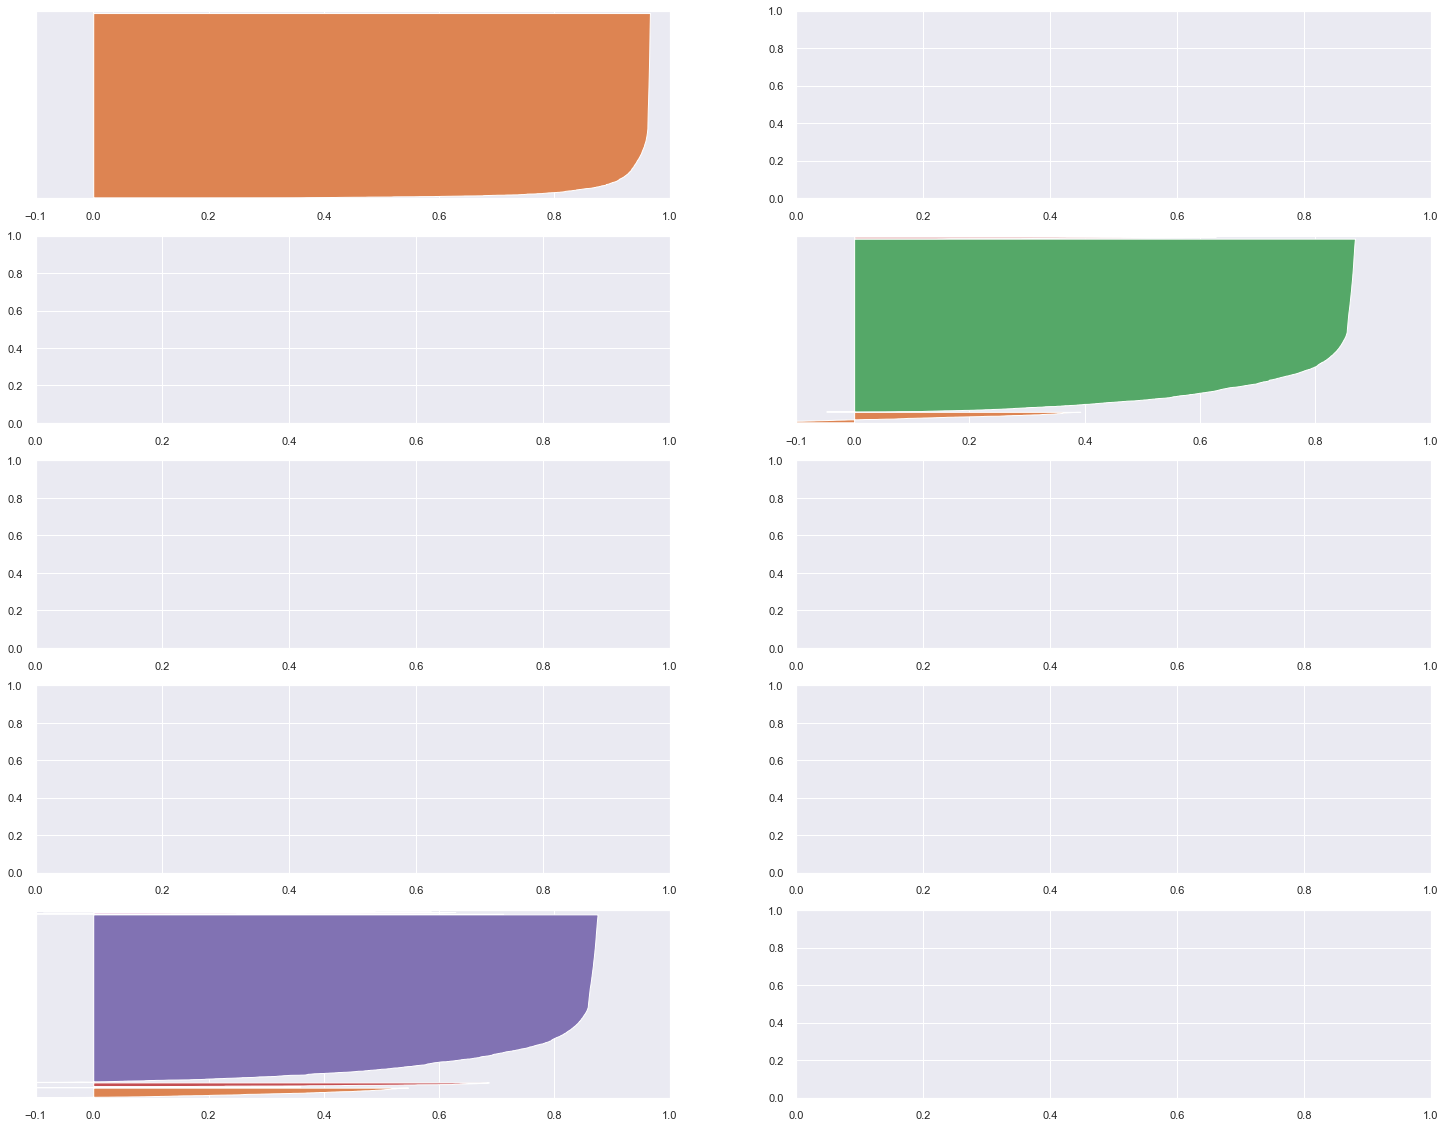

In [146]:
fig, ax = plt.subplots( 5, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# <font color='red'> 8.0 HYPERPARAMETER FINE TUNNING </font>

## 8.1. K-Means

In [147]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42) #max_iter iterações para achar o centróide

# model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [148]:
## WSS (within-cluster sum of square)
print('WSS Values: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS Values: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS Values: 20.053609757268116
SS Values: 0.9243534987515327


# <font color='red'> 9.0. Cluster Analysis </font>

In [149]:
df9 = df5_p.copy()
df9['cluster'] = labels
df9['customer_id'] = df5_p['customer_id']
df9.head()

,customer_id,quantity,unit_price,gross_revenue,total_returned,manual_p,total_postal,total_invoice,gross_revenue_adj,cluster
0,12346,74215,1.04,77183.60,-77183.6,0.0,0.0,2,0.00,0
1,12347,2458,481.21,4310.00,0.0,0.0,0.0,182,4310.00,2
2,12348,2332,18.71,1437.24,0.0,0.0,360.0,27,1437.24,1
3,12349,630,305.10,1457.55,0.0,0.0,300.0,72,1457.55,2
4,12350,196,25.30,294.40,0.0,0.0,40.0,16,294.40,2


## 9.1. Visualization Inspection

In [150]:
fig = px.scatter_3d(df9, x='quantity', y='unit_price', z='gross_revenue_adj', color='cluster')
fig.show()

## 9.2. 2d plot

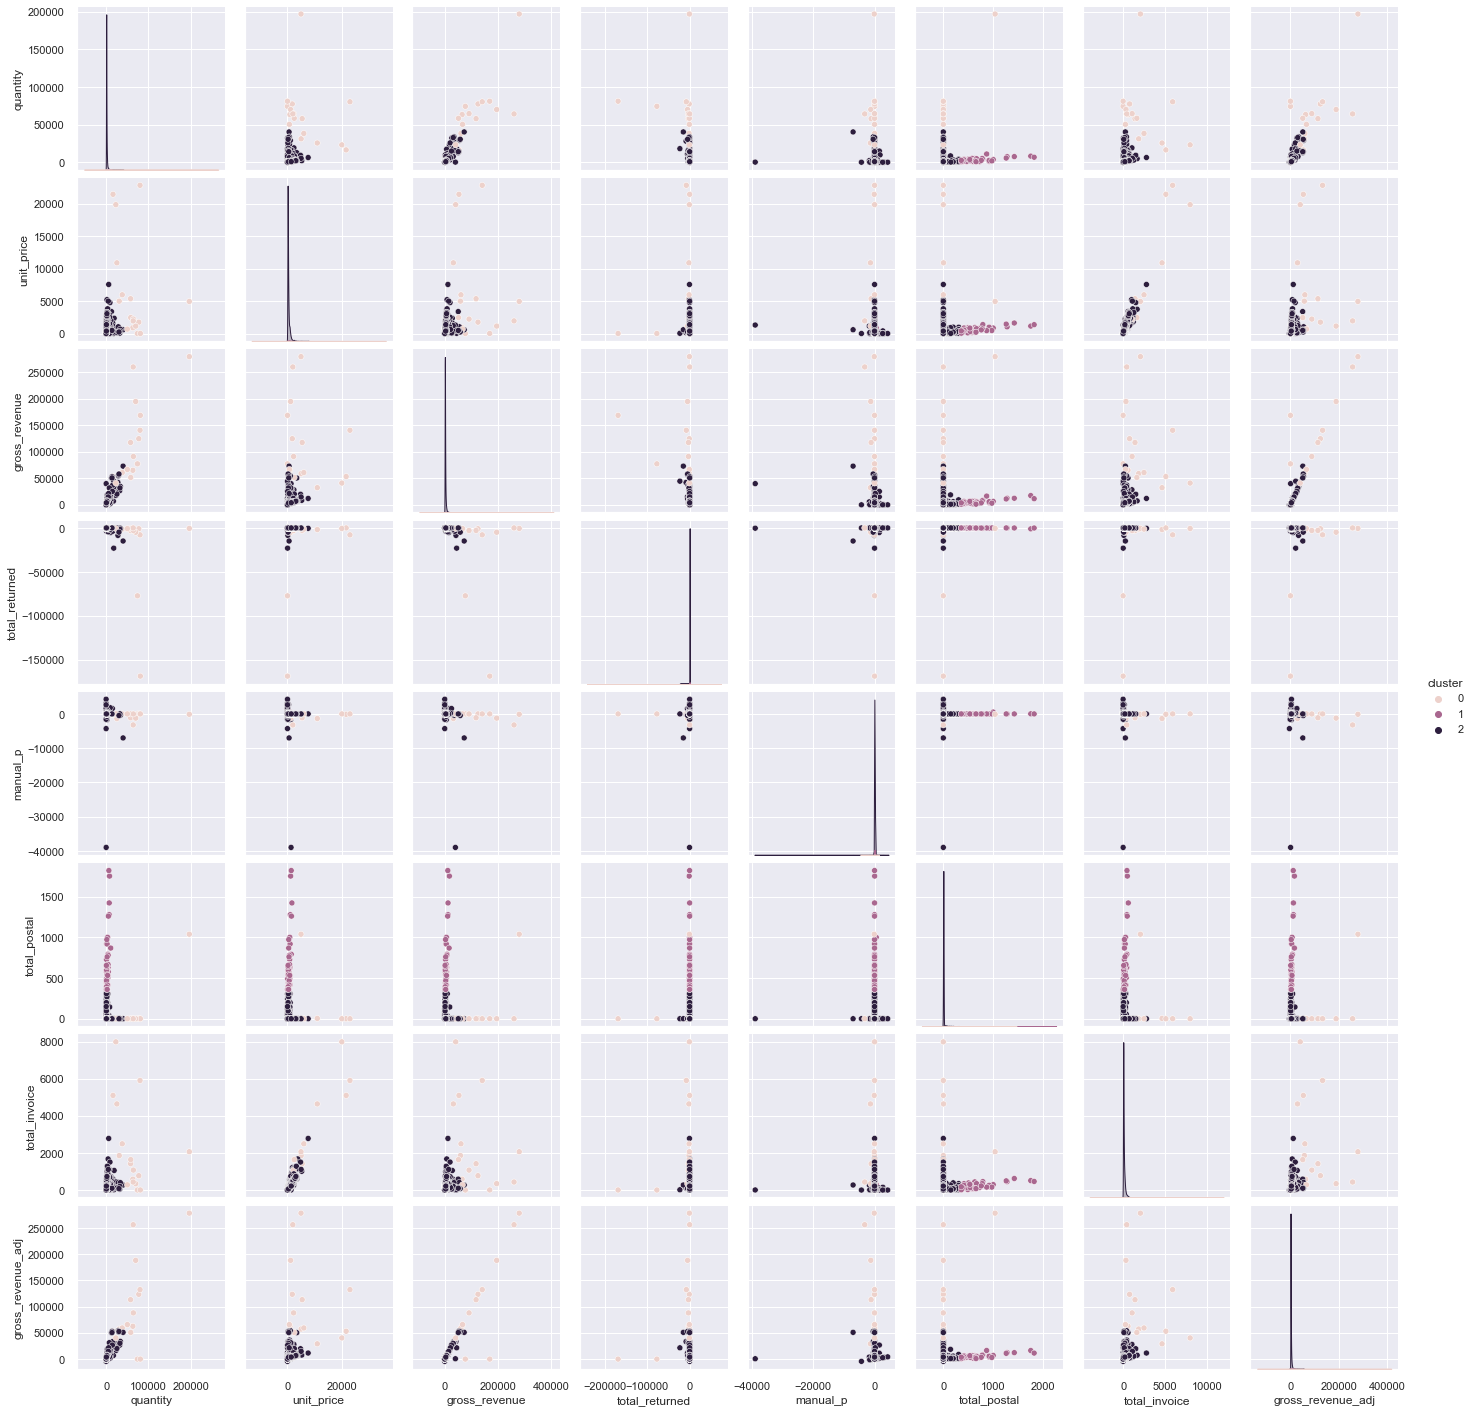

In [151]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster' )

In [155]:
df_cluster = pd.DataFrame()
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_gross_revenue['gross_revenue'] = df_avg_gross_revenue['gross_revenue'].apply(lambda x: np.round(x, 2))
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg quantity
df_avg_avg_qt = df9[['quantity', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_avg_qt['quantity'] = df_avg_avg_qt['quantity'].apply(lambda x: np.round(x, 2))
df_cluster = pd.merge(df_cluster, df_avg_avg_qt, how='inner', on='cluster')

# Avg unit price
df_avg_unit_price = df9[['unit_price', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_unit_price['unit_price'] = df_avg_unit_price['unit_price'].apply(lambda x: np.round(x, 2))
df_cluster = pd.merge(df_cluster, df_avg_unit_price, how='inner', on='cluster')

# Avg total returned
df_avg_total_returned = df9[['total_returned', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_total_returned['total_returned'] = df_avg_total_returned['total_returned'].apply(lambda x: np.round(x, 2))
df_cluster = pd.merge(df_cluster, df_avg_total_returned, how='inner', on='cluster')

# Avg total postal
df_avg_total_postal = df9[['total_postal', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_total_postal['total_postal'] = df_avg_total_postal['total_postal'].apply(lambda x: np.round(x, 2))
df_cluster = pd.merge(df_cluster, df_avg_total_postal, how='inner', on='cluster')

# Avg manual p
df_avg_manual_p = df9[['manual_p', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_manual_p['manual_p'] = df_avg_manual_p['manual_p'].apply(lambda x: np.round(x, 2))
df_cluster = pd.merge(df_cluster, df_avg_manual_p, how='inner', on='cluster')

# Avg invoice
df_avg_invoice_no = df9[['total_invoice', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_invoice_no['total_invoice'] = df_avg_invoice_no['total_invoice'].apply(lambda x: np.round(x, 2))
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg gross_revenue_adj
df_avg_gav_ajd = df9[['gross_revenue_adj', 'cluster']].groupby('cluster').mean().reset_index()
df_avg_gav_ajd['gross_revenue_adj'] = df_avg_gav_ajd['gross_revenue_adj'].apply(lambda x: np.round(x, 2))
df_cluster = pd.merge(df_cluster, df_avg_gav_ajd, how='inner', on='cluster')


df_cluster = df_cluster.rename(columns={'cluster' : 'cluster', 
                                        'customer_id' : 'total_of_customers',
                                        'perc_customer' : 'perc_customer',
                                        'gross_revenue': 'avg_gross_revenue',
                                        'unit_price' : 'avg_unit_price',
                                        'quantity' : 'avg_quantity',
                                        'manual_p': 'avg_manual_input_purchase',
                                        'total_returned' : 'avg_total_returned',
                                        'total_postal' : 'avg_total_postal',
                                        'total_invoice' : 'avg_invoice',
                                        'gross_revenue_adj': 'avg_gross_revenue_adj'
                                        
                                       })

## 9.1. Cluster Profile

In [156]:
df_cluster.sort_values('avg_gross_revenue_adj', ascending=False)

,cluster,total_of_customers,perc_customer,avg_gross_revenue,avg_quantity,avg_unit_price,avg_total_returned,avg_total_postal,avg_manual_input_purchase,avg_invoice,avg_gross_revenue_adj
0,0,17,0.294576,110695.13,63077.47,6309.59,-16162.66,61.29,-420.69,2152.35,94111.77
1,1,57,0.987697,4914.24,2851.79,584.98,-77.30,632.33,10.20,213.05,4847.13
2,2,5697,98.717727,1424.35,762.18,278.84,-35.28,4.73,-4.82,85.69,1384.25


### Cluster 01:  ( Candidate for Insiders )
    - Number of Customers: 17 (0.29% of customers )
    - Avg Invoice: 2152
    - Avg Gross Revenue Adjusted: $94.111,77
        
### Cluster 02: 
    - Number of Customers: 57 (0.98% of customers )
    - Avg Invoice: 213
    - Avg Gross Revenue Adjusted: $4.847,13
        
### Cluster 03: 
    - Number of Customers: 5697 (98,72% of customers )
    - Avg Invoice: 86
    - Avg Gross Revenue Adjusted: $1.384,25

In [157]:
# insiders cluster
df9[df9['cluster']==0]

,customer_id,quantity,unit_price,gross_revenue,total_returned,manual_p,total_postal,total_invoice,gross_revenue_adj,cluster
0,12346,74215,1.04,77183.60,-77183.60,0.00,0.0,2,0.00,0
55,12415,77373,1747.08,124564.53,-926.35,0.00,0.0,774,123638.18,0
330,12748,25511,10880.23,32317.32,-1830.79,-1338.43,4.0,4639,29148.10,0
568,13089,31070,4977.35,58825.83,-1439.95,0.00,0.0,1857,57385.88,0
1004,13694,63312,891.19,65039.62,-2362.52,-24.00,0.0,585,62653.10,0
1299,14096,16336,21426.09,53258.43,0.00,-110.45,0.0,5096,53147.98,0
1344,14156,57885,5357.68,117379.63,-2874.31,-1121.18,0.0,1420,113384.14,0
1446,14298,58343,2452.19,51527.30,-664.86,0.00,0.0,1640,50862.44,0
1702,14646,196844,4933.09,279138.02,-566.40,-105.60,1038.0,2064,278466.02,0
1894,14911,80263,22811.38,140450.72,-7878.10,0.00,0.0,5901,132572.62,0


In [163]:
# customer which haven´t really made a purchase or it is not possible to track the discounted value. we are going to remove it on next cicle.
df9[df9['gross_revenue_adj']<=0]['customer_id'].tolist()

[12346,
 12503,
 12505,
 12558,
 12605,
 12607,
 12666,
 12870,
 12943,
 13154,
 13364,
 13672,
 13693,
 13829,
 13958,
 14119,
 14213,
 14437,
 14557,
 14627,
 14679,
 14777,
 14792,
 15369,
 15590,
 15638,
 15728,
 15802,
 15823,
 16061,
 16138,
 16252,
 16262,
 16428,
 16454,
 16546,
 16579,
 16742,
 16878,
 16995,
 17065,
 17307,
 17448,
 17547,
 17548,
 17603,
 17820,
 18141,
 18256,
 18268,
 18274]

# <font color='red'> 10.0. Deploy To Production </font>